In [ ]:
!pip install yfinance filterpy --quiet

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from filterpy.kalman import KalmanFilter
import yfinance as yf


In [ ]:
def fetch_intraday_data(ticker="AAPL", interval="5m", period="5d"):
    df = yf.download(ticker, interval=interval, period=period)
    df = df[['Close']].dropna()
    return df

df = fetch_intraday_data()
df.head()


/tmp/ipython-input-54-1959505215.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, interval=interval, period=period)
[*********************100%***********************]  1 of 1 completed


Price,Close
Ticker,AAPL
Datetime,
2025-07-01 13:30:00+00:00,207.039993
2025-07-01 13:35:00+00:00,207.684998
2025-07-01 13:40:00+00:00,207.529999
2025-07-01 13:45:00+00:00,208.769806
2025-07-01 13:50:00+00:00,208.779999


In [ ]:
from filterpy.kalman import KalmanFilter
import numpy as np

def apply_kalman_filter(prices):
    """
    Applies a 1D Kalman Filter to denoise a price series.

    Args:
        prices (pd.Series): Time series of prices.

    Returns:
        np.ndarray: Kalman filtered prices.
    """
    kf = KalmanFilter(dim_x=2, dim_z=1)
    initial_price = float(prices.iloc[0])
    kf.x = np.array([[initial_price], [0.]])  # initial state: [price, velocity]

    # System dynamics
    kf.F = np.array([[1., 1.], [0., 1.]])     # State transition matrix
    kf.H = np.array([[1., 0.]])               # Measurement function

    # Covariance and noise settings
    kf.P *= 1.0                               # Initial state covariance
    kf.R = 0.04                               # Measurement noise (adjustable)
    kf.Q = np.array([[1e-6, 0.], [0., 1e-6]]) # Process noise (adjustable)

    # Run the filter
    filtered = []
    for price in prices.values:  # Iterate over the values
        kf.predict()
        kf.update(float(price))
        filtered.append(kf.x[0, 0])
    return np.array(filtered)

In [ ]:
df['kf'] = apply_kalman_filter(df['Close'])
df['ma_10'] = df[('Close', 'AAPL')].rolling(10).mean()
display(df.tail())

/tmp/ipython-input-55-2885764269.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  initial_price = float(prices.iloc[0])
/tmp/ipython-input-55-2885764269.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  kf.update(float(price))


Price,Close,kf,ma_10
Ticker,AAPL,,
Datetime,,,
2025-07-08 19:35:00+00:00,209.414993,209.597160,209.582788
2025-07-08 19:40:00+00:00,209.521301,209.570897,209.560918
2025-07-08 19:45:00+00:00,209.695007,209.563453,209.560419
2025-07-08 19:50:00+00:00,210.089996,209.594985,209.608899
2025-07-08 19:55:00+00:00,210.035004,209.620625,209.647400


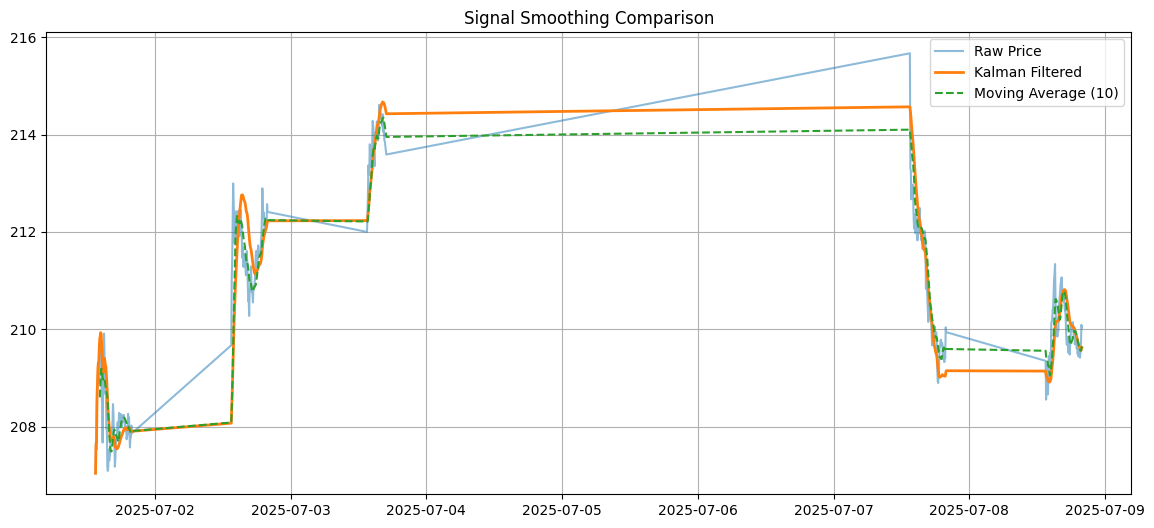

In [ ]:
plt.figure(figsize=(14,6))
plt.plot(df['Close'], label='Raw Price', alpha=0.5)
plt.plot(df['kf'], label='Kalman Filtered', linewidth=2)
plt.plot(df['ma_10'], label='Moving Average (10)', linestyle='--')
plt.title("Signal Smoothing Comparison")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
def signal_to_noise_ratio_db(signal, smoothed):
    # Align signal and smoothed and drop NaNs that result from the alignment
    aligned_signal, aligned_smoothed = signal.align(smoothed, join='inner', fill_value=np.nan, axis=0)
    aligned_signal = aligned_signal.dropna()
    aligned_smoothed = aligned_smoothed.dropna()

    # Ensure aligned data is not empty before calculating variance
    if aligned_signal.empty or aligned_smoothed.empty:
        return np.nan # Return NaN if no valid data points

    residual = aligned_signal - aligned_smoothed

    # Ensure scalar variance calculation by operating on values and specifying axis
    signal_power = np.var(aligned_smoothed.values)
    noise_power = np.var(residual.values)

    # Handle potential division by zero if noise_power is zero
    if noise_power == 0:
        # If signal_power is also zero, SNR is undefined (NaN or 0 depending on context)
        if signal_power == 0:
            return np.nan
        return np.inf

    # Ensure scalar output from the division and log calculation
    return 10 * np.log10(signal_power / noise_power)

In [ ]:
snr_kf = signal_to_noise_ratio_db(df[('Close', 'AAPL')], df['kf'])
snr_ma = signal_to_noise_ratio_db(df[('Close', 'AAPL')], df['ma_10'].dropna())

print(f"SNR (Kalman Filter): {snr_kf:.2f} dB")
print(f"SNR (Moving Average): {snr_ma:.2f} dB")

SNR (Kalman Filter): 8.89 dB
SNR (Moving Average): 10.15 dB
